# Custom regression model

## Extracting the seasonality 

<AxesSubplot:xlabel='weekofyear'>

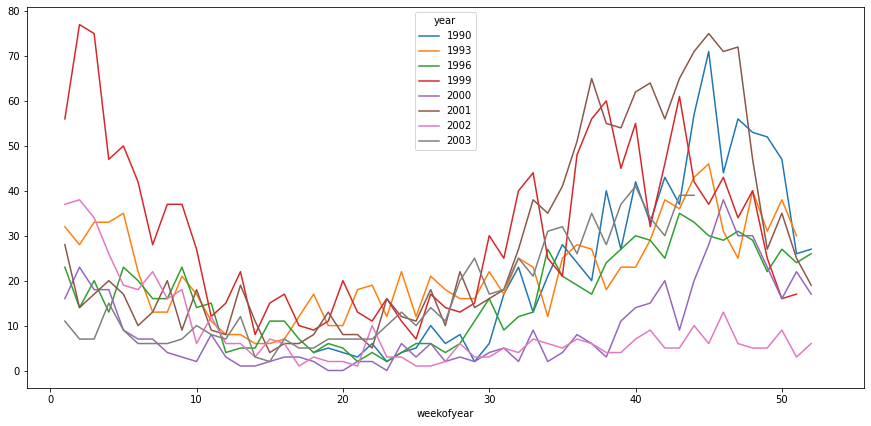

In [39]:
(
    sj_train_train
    .pivot(index='weekofyear', columns='year', values='total_cases')
#     .T
#     .lt(100)
#     .any()
    .loc[:,lambda df: df.max(axis=0) < 100]
    .plot()
)

In [40]:
# This is for now fixed to a 3 week centered rolling mean, should later be generalised!

def get_smooth_seasonality_df(df, colnames, cutoff=1000):
    '''
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    Output:
    Pandas dataframe with seasonalities
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .loc[:,lambda df: df.max(axis=0) < cutoff]
            .mean(axis=1)
        )
        jan = pd.Series(weekly[1])
        jan.index = [len(weekly)+1]

        dec = pd.Series(weekly[len(weekly)])
        dec.index = [weekly.index[0]-1]

        weekly = weekly.append(jan)
        weekly = weekly.append(dec)

        smooth_seasonality = (
            weekly
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df = df.reset_index()
    df = df.rename(columns={'index': 'weekofyear'})
    return df

In [41]:
sj_train_train_seas = get_smooth_seasonality_df(sj_train_train, 'total_cases', cutoff=150)
sj_train_train_seas.head()

,weekofyear,total_cases
0,1,38.537037
1,2,35.814815
2,3,34.629630
3,4,31.666667
4,5,26.888889


## Evaluating the saisonality as a baseline model

In [42]:
def seasonality_for_test(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    return eval_df.iloc[:,2]

In [43]:
# seasonality_for_test(sj_train_test, sj_train_train_seas)

In [44]:
def seasonality_baseline_eval(df_test, seas):
    eval_df = (
        df_test
        .loc[:,['weekofyear', 'total_cases']]
        .merge(seas,
               how='left',
               on='weekofyear',
               suffixes=('','_seas')
              )
    )
    (
        eval_df
        .iloc[:,1:]
        .plot()
    )
    model_classification(eval_df.iloc[:,1], eval_df.iloc[:,2])

--------------------
RMSE: 27.5
--------------------
MAE: 18.12
Explained variance: 0.076
--------------------


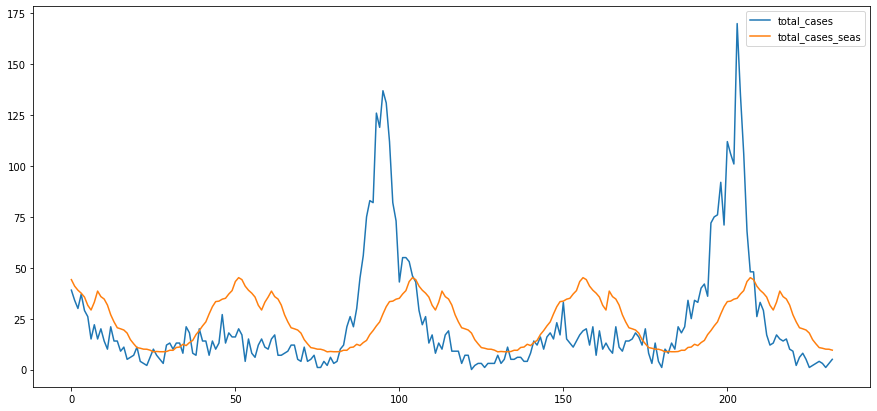

In [45]:
seasonality_baseline_eval(sj_train_test, sj_train_train_seas)

In [46]:
# set dictionary to access colors
colors= {'actual_weekly':'#a2bffe',
         'actual_monthly':'#26538d',
         'predicted_weekly':'coral',
         'predicted_monthly':'sienna'}

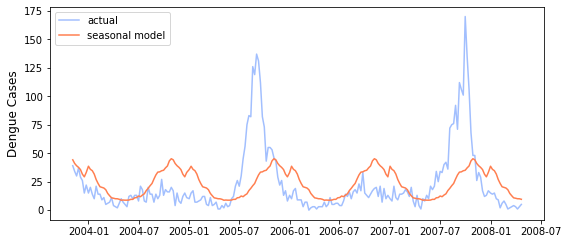

In [102]:
plot_df = (
    sj_train_test
    .loc[:,['weekofyear', 'total_cases']]
    .merge(sj_train_train_seas,
           how='left',
           on='weekofyear',
           suffixes=('','_seas')
          )
    .iloc[:,1:]
)
plot_df.index = sj_train_test.index
fig, ax = plt.subplots(figsize=(8, 3.5))
plt.plot(plot_df.index, plot_df.total_cases, color=colors['actual_weekly'])
plt.plot(plot_df.index, plot_df.total_cases_seas, color=colors['predicted_weekly'])
ax.set_ylabel('Dengue Cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)
ax.legend(labels=['actual', 'seasonal model'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig('plots/SJ_train_test_seasonal_model.png', dpi=200)

# Poisson Regression

## Substracting the saisonality

In [48]:
def substract_seas(df, cols, seas_model, drop=False):
    if type(cols) == str:
        cols = [cols]
    df_mod = (
        df
        .merge(
            seas_model,
            how='left', 
            on='weekofyear',
            suffixes=('','_seas_model')
            )
    )
    for i in range(len(cols)):
        kwargs = {'%s_wo_seas' % cols[i]: lambda df: df[cols[i]] - df['%s_seas_model' % cols[i]]}
        df_mod = (
            df_mod
            .assign(**kwargs)
    )
    if drop == True:
        df_mod = df_mod.drop(cols, axis=1)
        old_cols = [col for col in df_mod.columns if '_seas_model' in col]
        df_mod = df_mod.drop(old_cols, axis=1)
    df_mod.index = df.index
    return df_mod

In [49]:
sj_train_train = substract_seas(sj_train_train, 'total_cases', sj_train_train_seas)
sj_train_test = substract_seas(sj_train_test, 'total_cases', sj_train_train_seas)

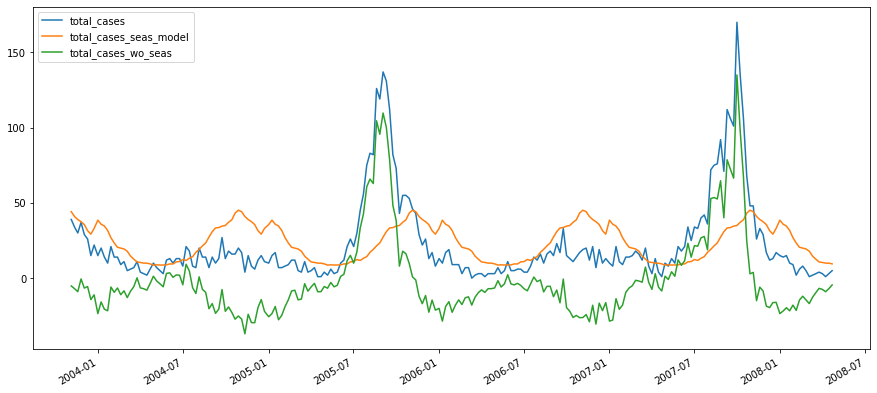

In [50]:
(
    sj_train_test
    .loc[:,['total_cases', 'total_cases_seas_model', 'total_cases_wo_seas']]
    .plot()
);

### Imports

In [295]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

In [296]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [297]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

In [298]:
from sklearn.model_selection import GridSearchCV

### Settings

In [299]:
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [300]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

### Helper functions
Sort out in the end!!!

In [301]:
def model_classification(actual, predicted):
    '''
    Prints out RSME, MAE and explained variance score
    '''
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [302]:
def custom_dropper(df, cols):
    '''
    Drops rows of a data frame that have missing values in some of the columns.
    ------------------
    In: 
    df: a data frame
    cols: columns in which to look for missing values
    ------------------
    Out: a data frame
    '''
    return df[df.index.isin(df[cols].dropna().index)]

In [303]:
# This is a copy from above
def env_cols(df):
    '''
    Returns a list of only environmental variables (that can be lagged).
    '''
    cols = df.columns.to_list()
    unwanted = ['week_start_date',
                'city',
                'year',
                'weekofyear',
                'month',
                'total_cases',
                'total_cases_o_seas',
                'total_cases_wo_seas'
               ]
    return [e for e in cols if e not in unwanted]

In [304]:
def reduce_features_lda_bins(df, df_train, cols, target, n_comps=2, n_bins=2):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_train[cols])
    df_scaled = pd.DataFrame(data=scaled, columns=cols)
    lda = LDA(n_components=n_comps)
    lda.fit(df_scaled.dropna(),
            pd.cut(custom_dropper(df_train, cols)[target], n_bins, labels=False))
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

### Loading and preparing the data

In [305]:
sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = pickle.load(open('data_subsets_lags.pickle', 'rb'))

In [306]:
sj_test.index.name = None
iq_test.index.name = None

In [307]:
sj_train = pd.concat([sj_train_train, sj_train_test], axis=0)
iq_train = pd.concat([iq_train_train, iq_train_test], axis=0)

In [308]:
# Ist im feature engineering!!!
def fill_from_train(df_test, df_train):
    null_cols = df_test.columns[df_test.isnull().any()]
    df_miss = df_test.loc[:,df_test[null_cols].columns]

    for i in range(df_miss.shape[1]):
        colname_miss = df_miss.iloc[:,i].name
        n_miss = df_miss.iloc[:,i].isnull().sum()
        data_for_gap = df_train.loc[:,colname_miss].iloc[-n_miss:]
        df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values

    return df_test

In [309]:
sj_train_test = fill_from_train(sj_train_test, sj_train_train)
iq_train_test = fill_from_train(iq_train_test, iq_train_train)

sj_test = fill_from_train(sj_test, sj_train)
iq_test = fill_from_train(iq_test, iq_train)

/tmp/ipykernel_460315/1657523241.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, colname_miss][df_test.loc[:, colname_miss].isnull()] = data_for_gap.values


## Part 1: San Juan Validation

### Feature selection

In [310]:
# This is for now fixed to a 3 week centered rolling mean, should later be generalised!

def get_smooth_seasonality_df(df, colnames, cutoff=1000):
    '''
    Inputs:
    df: dataframe with the variables 'year' and 'weekofyear'
    colnames: a list of names of variables for which to get the seasonality
    Output:
    Pandas dataframe with seasonalities
    '''
    if type(colnames) == str:
        colnames = [colnames]
    l = []
    for i in range(len(colnames)):
        weekly = (
            df
            .pivot(index='weekofyear', columns='year', values=colnames[i])
            .loc[:,lambda df: df.max(axis=0) < cutoff]
            .mean(axis=1)
        )
        jan = pd.Series(weekly[1])
        jan.index = [len(weekly)+1]

        dec = pd.Series(weekly[len(weekly)])
        dec.index = [weekly.index[0]-1]

        weekly = weekly.append(jan)
        weekly = weekly.append(dec)

        smooth_seasonality = (
            weekly
            .sort_index()
            .rolling(window=3, center=True)
            .mean()
            .dropna()
        )
        smooth_seasonality.name = colnames[i]
        l.append(smooth_seasonality)
    
    df = pd.DataFrame(l).T
    df = df.reset_index()
    df = df.rename(columns={'index': 'weekofyear'})
    return df

In [311]:
sj_train_train_seas = get_smooth_seasonality_df(sj_train_train, 'total_cases', cutoff=150)
sj_train_train_seas.head()

,weekofyear,total_cases
0,1,38.537037
1,2,35.814815
2,3,34.629630
3,4,31.666667
4,5,26.888889


In [312]:
def substract_seas(df, cols, seas_model, drop=False):
    if type(cols) == str:
        cols = [cols]
    df_mod = (
        df
        .merge(
            seas_model,
            how='left', 
            on='weekofyear',
            suffixes=('','_seas_model')
            )
    )
    for i in range(len(cols)):
        kwargs = {'%s_wo_seas' % cols[i]: lambda df: df[cols[i]] - df['%s_seas_model' % cols[i]]}
        df_mod = (
            df_mod
            .assign(**kwargs)
    )
    if drop == True:
        df_mod = df_mod.drop(cols, axis=1)
        old_cols = [col for col in df_mod.columns if '_seas_model' in col]
        df_mod = df_mod.drop(old_cols, axis=1)
    df_mod.index = df.index
    return df_mod

In [313]:
sj_train_train = substract_seas(sj_train_train, 'total_cases', sj_train_train_seas)
sj_train_test = substract_seas(sj_train_test, 'total_cases', sj_train_train_seas)

In [314]:
def get_env_features(df):
    return (
        df.drop([
          'total_cases',
           'week_start_date',
           'city',
           'year',
           'total_cases_wo_seas',
           'weekofyear'
        ], axis=1)
        .columns
        .to_list()
    )
env_features = get_env_features(sj_train_train)

In [315]:
def reduce_features_lda_border(df, df_train, cols, target, border=100):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(df_train[cols])
    df_scaled_train = pd.DataFrame(data=scaled_train, columns=cols)
    lda = LDA(n_components=1)
    lda.fit(df_scaled_train.dropna(),
                        np.where(custom_dropper(df_train, cols)[target] > border, 1, 0).tolist())
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

In [316]:
def add_dev_from_seas(df, df_train, cols, border):
    deviation = reduce_features_lda_border(df, df_train, cols, 'total_cases_wo_seas', border)
    deviation.columns = ['deviation']
    return df.join(deviation)

In [317]:
sj_train_train = add_dev_from_seas(sj_train_train, sj_train_train, env_features, 150)
sj_train_test = add_dev_from_seas(sj_train_test, sj_train_train, env_features, 150)

In [318]:
def get_highest_corr_features(df, n):
    corr_mat = df.corr()
    return (
        corr_mat['total_cases']
        .drop([
            'total_cases',
            'year',
            'total_cases_wo_seas',
            'weekofyear'])
        .abs()
        .sort_values()
        .tail(n)
        .index
    )
my_features = get_highest_corr_features(sj_train_train, 50)

In [319]:
my_features = list( get_highest_corr_features(sj_train_train, 50) )

In [320]:
my_features.append('total_cases_seas_model')
my_features.append('deviation')

### Preprocessing for Sklearn

In [321]:
X_train = sj_train_train[my_features].dropna()
X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

### Scaling

In [322]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [323]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [324]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [325]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [326]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

### Smoothing

In [327]:
def lossless_centered_smoothing(test_pred, train_y, w=3):
    if w // 2 == 0:
        print('w has to be an odd number to keep things simple while still doing centered smoothing')
        return
    else:
        
        trunk = train_y.rolling(window=w).mean()[-int((w-1) / 2):]
        tail = test_pred.rolling(window=w).mean()[-int((w-1) / 2):]

        smoothed = test_pred.rolling(window=w, center=True).mean()
        smoothed[:int((w-1) / 2)] = trunk
        smoothed[-int((w-1) / 2):] = tail

    return smoothed

### Evaluation

In [328]:
def evaluate_pred_val(y, y_pred, y_train, w):
    y.plot()
    y_pred.plot()
    lossless_centered_smoothing(y_pred, y_train, w=w).plot();
    print('Raw:')
    model_classification(y, y_pred)
    print('\nWith smoothing:')
    model_classification(y, lossless_centered_smoothing(y_pred, y_train, w=w))

Raw:
--------------------
RMSE: 5.44
--------------------
MAE: 3.89
Explained variance: 0.991
--------------------

With smoothing:
--------------------
RMSE: 13.57
--------------------
MAE: 7.91
Explained variance: 0.943
--------------------


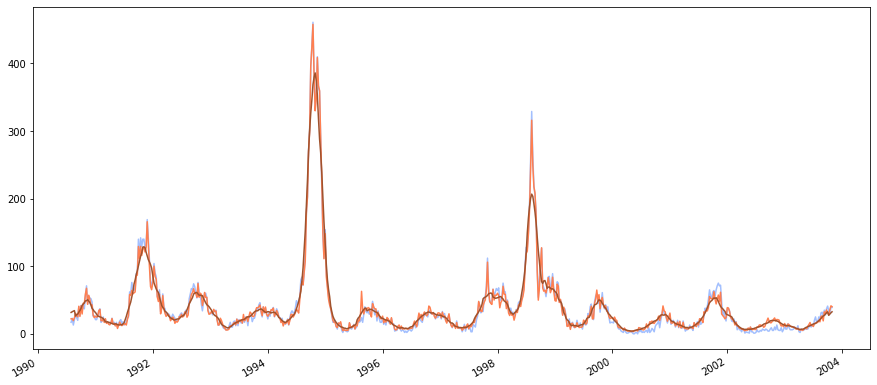

In [329]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

Raw:
--------------------
RMSE: 41.41
--------------------
MAE: 25.39
Explained variance: -0.903
--------------------

With smoothing:
--------------------
RMSE: 33.49
--------------------
MAE: 23.62
Explained variance: -0.177
--------------------


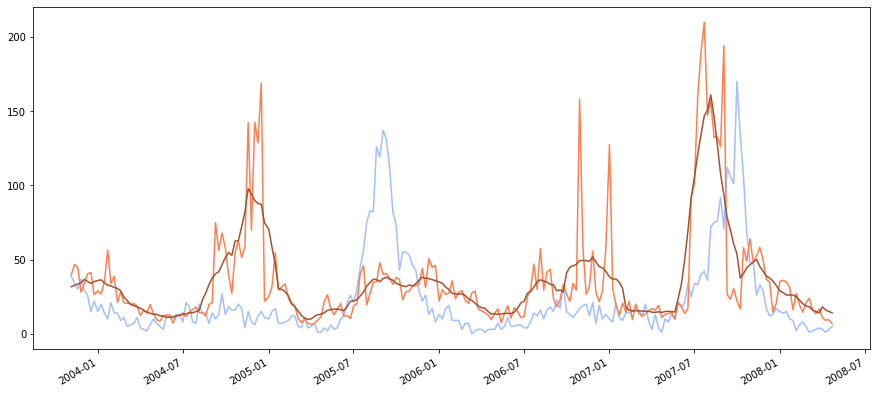

In [330]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=9)

In [331]:
# set dictionary to access colors
colors= {'actual_weekly':'#a2bffe',
         'actual_monthly':'#26538d',
         'predicted_weekly':'coral',
         'predicted_monthly':'sienna'}

<AxesSubplot:>

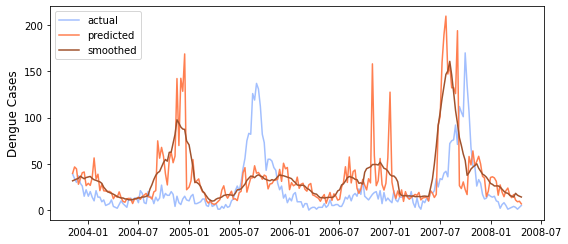

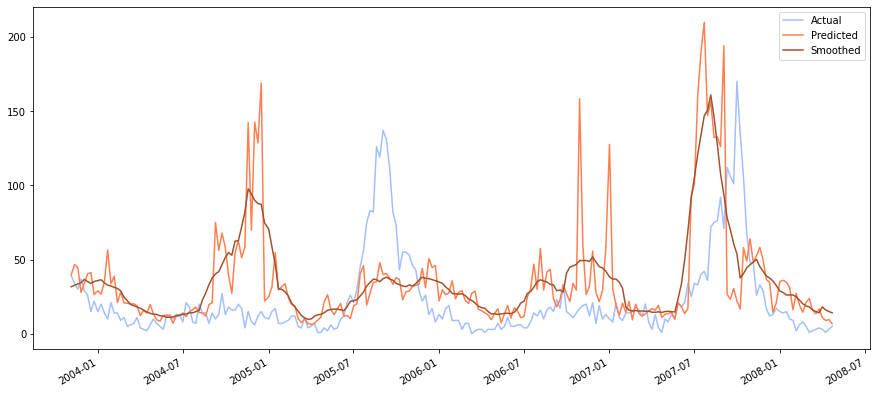

In [332]:
fig, ax = plt.subplots(figsize=(8, 3.5))
plt.plot(y_test.index, y_test, color=colors['actual_weekly'])
plt.plot(y_test.index, y_test_pred, color=colors['predicted_weekly'])
plt.plot(y_test.index, lossless_centered_smoothing(y_test_pred, y_train, w=9), color=colors['predicted_monthly'])
ax.set_ylabel('Dengue Cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)
ax.legend(labels=['actual', 'predicted', 'smoothed'])
fig.tight_layout()
fig.savefig('plots/SJ_seasonal_poisson_regression_train_test.png', dpi=200)
plot_df.plot()

## Part 2: San Juan Test Data

### Feature selection

In [333]:
sj_train_seas = get_smooth_seasonality_df(sj_train, 'total_cases', cutoff=150)
sj_train_seas.head()

,weekofyear,total_cases
0,1,30.564103
1,2,29.358974
2,3,28.051282
3,4,25.461538
4,5,21.615385


In [334]:
sj_train = substract_seas(sj_train, 'total_cases', sj_train_seas)

In [335]:
sj_train.head()

,week_start_date,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,...,cum_precip_6w_lag1,cum_precip_6w_lag2,cum_precip_6w_lag3,cum_precip_6w_lag4,cum_precip_6w_lag5,cum_precip_6w_lag6,cum_precip_6w_lag7,cum_precip_6w_lag8,total_cases_seas_model,total_cases_wo_seas
1990-04-30,1990-04-30,sj,1990,18,0.122600,0.103725,0.198483,0.177617,32.00,73.365714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.820513,-3.820513
1990-05-07,1990-05-07,sj,1990,19,0.169900,0.142175,0.162357,0.155486,17.94,77.368571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.051282,-3.051282
1990-05-14,1990-05-14,sj,1990,20,0.032250,0.172967,0.157200,0.170843,26.10,82.052857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.923077,-3.923077
1990-05-21,1990-05-21,sj,1990,21,0.128633,0.245067,0.227557,0.235886,13.90,80.337143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.205128,-5.205128
1990-05-28,1990-05-28,sj,1990,22,0.196200,0.262200,0.251200,0.247340,12.20,80.460000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.717949,-2.717949


In [336]:
sj_train_seas.head()

,weekofyear,total_cases
0,1,30.564103
1,2,29.358974
2,3,28.051282
3,4,25.461538
4,5,21.615385


In [337]:
def add_seas_model(df, seas_model):
    df_index = df.index
    seas_model = seas_model.rename(columns={'total_cases': 'total_cases_seas_model'})
    df = df.merge(seas_model, how='left', on='weekofyear')
    df.index = df_index
    return df

In [338]:
sj_test = add_seas_model(sj_test, sj_train_seas)

In [339]:
env_features = get_env_features(sj_train)

In [340]:
sj_train = add_dev_from_seas(sj_train, sj_train, env_features, 150)
sj_test = add_dev_from_seas(sj_test, sj_train, env_features, 150)

In [341]:
my_features = list( get_highest_corr_features(sj_train, 50) )

In [342]:
my_features.append('total_cases_seas_model')
my_features.append('deviation')

### Preprocessing for Sklearn

In [343]:
X_train = sj_train[my_features].dropna()
X_test = sj_test[my_features].dropna()

y_train = custom_dropper(sj_train, my_features).total_cases

### Scaling

In [344]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [345]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [346]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [347]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [348]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = sj_test.index

### Evaluation

Raw:
--------------------
RMSE: 4.61
--------------------
MAE: 3.4
Explained variance: 0.992
--------------------

With smoothing:
--------------------
RMSE: 12.5
--------------------
MAE: 7.21
Explained variance: 0.942
--------------------


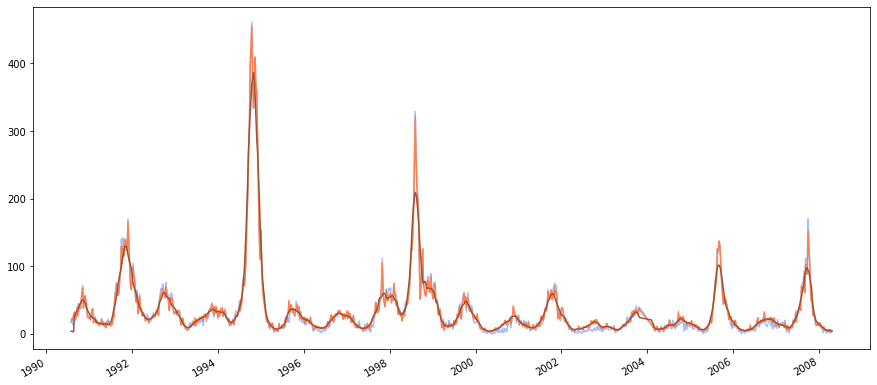

In [349]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

In [350]:
def evaluate_pred_test(y_pred, y_train, w):
    y_pred.plot(color='C01')
    lossless_centered_smoothing(y_pred, y_train, w=w).plot(color='C02');

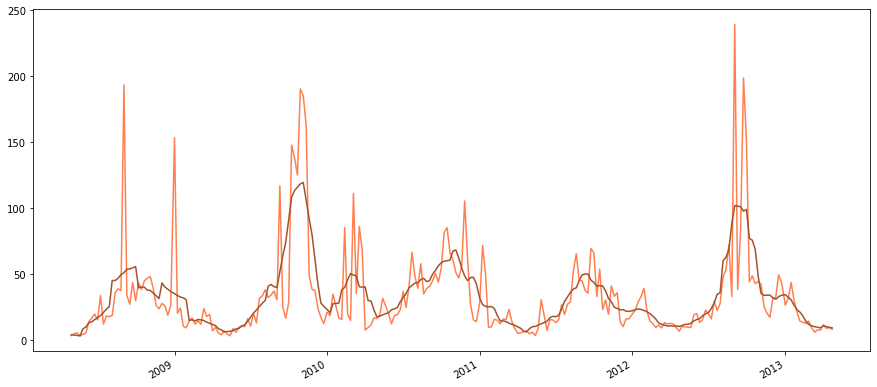

In [351]:
evaluate_pred_test(y_test_pred, y_train, w=9)

In [352]:
# Save the predictions for the submission
sj_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=5)

## Part 3: Iquitos Validation

### Feature selection

In [353]:
iq_train_train_seas = get_smooth_seasonality_df(iq_train_train, 'total_cases', cutoff=60)
iq_train_train_seas.head()

,weekofyear,total_cases
0,1,13.666667
1,2,14.666667
2,3,16.333333
3,4,15.555556
4,5,16.888889


In [354]:
iq_train_train = substract_seas(iq_train_train, 'total_cases', iq_train_train_seas)
iq_train_test = substract_seas(iq_train_test, 'total_cases', iq_train_train_seas)

In [355]:
env_features = get_env_features(iq_train_train)

In [356]:
iq_train_train = add_dev_from_seas(iq_train_train, iq_train_train, env_features, 60)
iq_train_test = add_dev_from_seas(iq_train_test, iq_train_train, env_features, 60)

In [357]:
my_features = list( get_highest_corr_features(sj_train_train, 50) )

In [358]:
my_features.append('total_cases_seas_model')
my_features.append('deviation')

### Preprocessing for Sklearn

In [359]:
X_train = iq_train_train[my_features].dropna()
X_test = iq_train_test[my_features].dropna()

y_train = custom_dropper(iq_train_train, my_features).total_cases
y_test = custom_dropper(iq_train_test, my_features).total_cases

### Scaling

In [360]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [361]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [362]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [363]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [364]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

### Evaluation

Raw:
--------------------
RMSE: 1.44
--------------------
MAE: 1.14
Explained variance: 0.984
--------------------

With smoothing:
--------------------
RMSE: 7.08
--------------------
MAE: 3.62
Explained variance: 0.607
--------------------


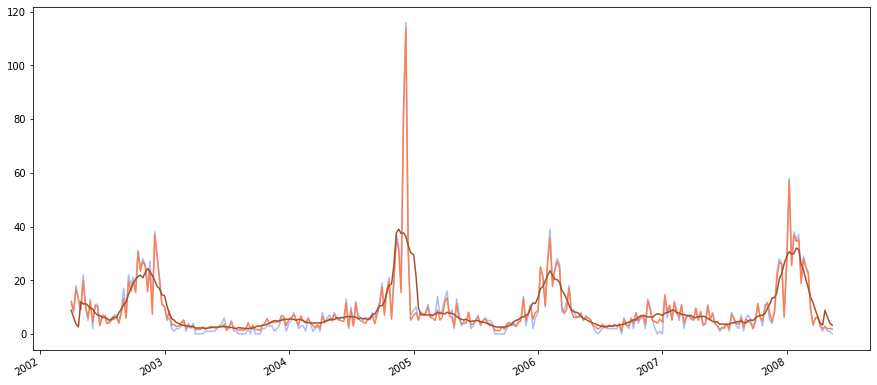

In [365]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

Raw:
--------------------
RMSE: 11.4
--------------------
MAE: 7.84
Explained variance: 0.038
--------------------

With smoothing:
--------------------
RMSE: 10.83
--------------------
MAE: 7.35
Explained variance: 0.135
--------------------


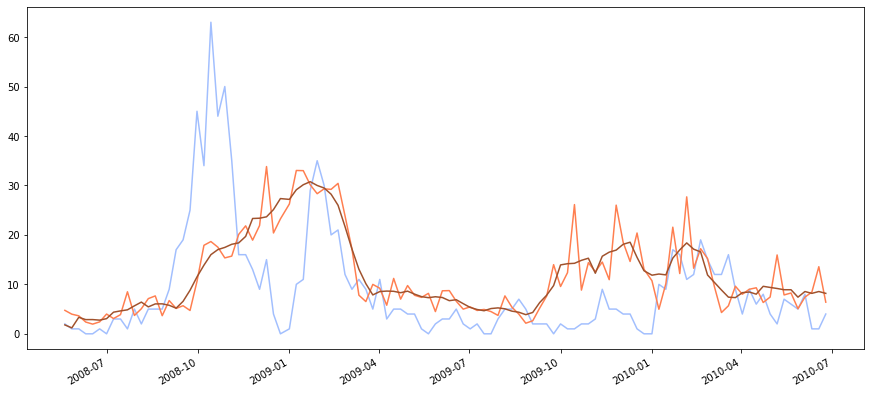

In [366]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=5)

<AxesSubplot:>

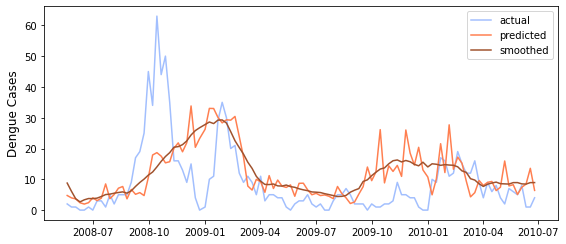

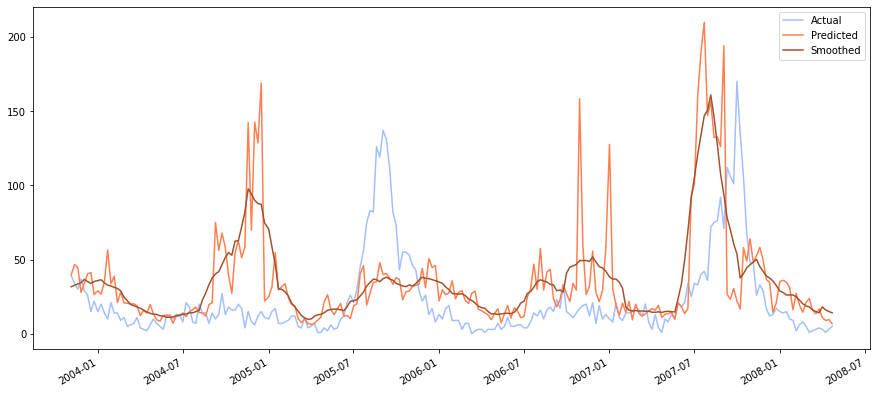

In [367]:
fig, ax = plt.subplots(figsize=(8, 3.5))
plt.plot(y_test.index, y_test, color=colors['actual_weekly'])
plt.plot(y_test.index, y_test_pred, color=colors['predicted_weekly'])
plt.plot(y_test.index, lossless_centered_smoothing(y_test_pred, y_train, w=9), color=colors['predicted_monthly'])
ax.set_ylabel('Dengue Cases', fontsize=12)
ax.set_xlabel('')
ax.tick_params(labelsize=10)
ax.legend(labels=['actual', 'predicted', 'smoothed'])
fig.tight_layout()
fig.savefig('plots/IQ_seasonal_poisson_regression_train_test.png', dpi=200)
plot_df.plot()

## Part 3: Iquitos Test Data

### Feature selection

In [368]:
iq_train_seas = get_smooth_seasonality_df(iq_train, 'total_cases', cutoff=150)
iq_train_seas.head()

,weekofyear,total_cases
0,1,10.055556
1,2,12.555556
2,3,14.962963
3,4,15.333333
4,5,16.555556


In [369]:
iq_train = substract_seas(iq_train, 'total_cases', iq_train_seas)

In [370]:
iq_test = add_seas_model(iq_test, iq_train_seas)

In [371]:
env_features = get_env_features(iq_train)

In [372]:
iq_train = add_dev_from_seas(iq_train, iq_train, env_features, 60)
iq_test = add_dev_from_seas(iq_test, iq_train, env_features, 60)

In [373]:
my_features = list( get_highest_corr_features(sj_train_train, 50) )

In [374]:
my_features.append('total_cases_seas_model')
my_features.append('deviation')

### Preprocessing for Sklearn

In [375]:
X_train = iq_train[my_features].dropna()
X_test = iq_test[my_features].dropna()

y_train = custom_dropper(iq_train, my_features).total_cases

### Scaling

In [376]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [377]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [378]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [379]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [380]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = iq_test.index

### Evaluation

Raw:
--------------------
RMSE: 1.33
--------------------
MAE: 1.07
Explained variance: 0.986
--------------------

With smoothing:
--------------------
RMSE: 6.71
--------------------
MAE: 3.59
Explained variance: 0.654
--------------------


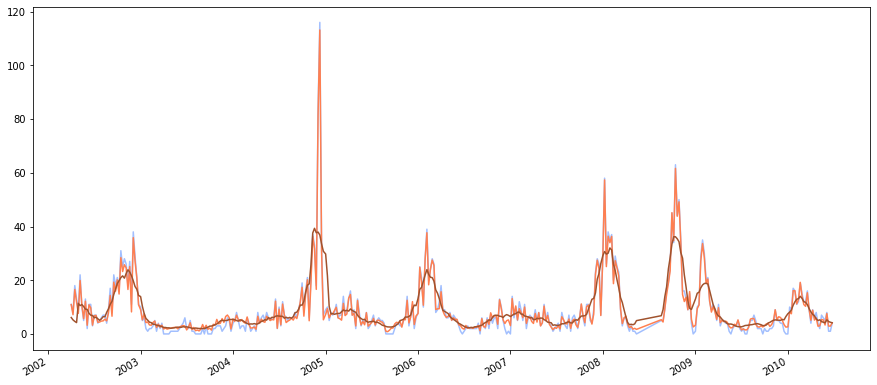

In [381]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9)

In [382]:
def evaluate_pred_test(y_pred, y_train, w):
    y_pred.plot(color='C01')
    lossless_centered_smoothing(y_pred, y_train, w=w).plot(color='C02');

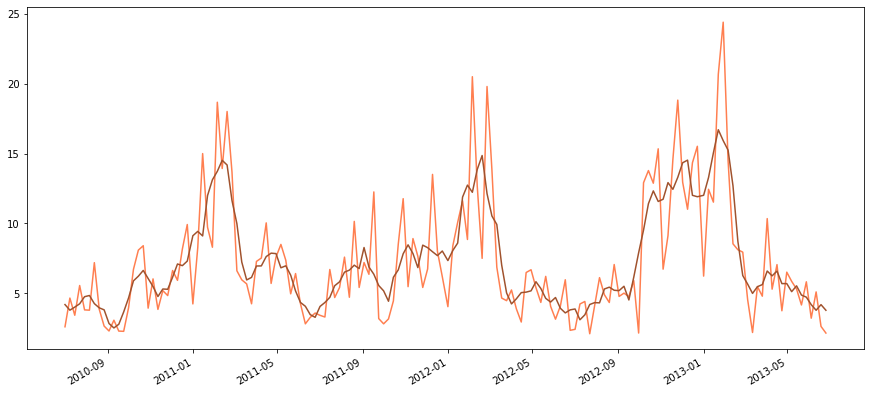

In [383]:
evaluate_pred_test(y_test_pred, y_train, w=5)

In [384]:
# Save the predictions for the submission
iq_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=5)

## Submission

In [385]:
def subm_builder_ind_city(pred, test_df):
    pred = pred.reset_index().rename(columns={
        'index': 'week_start_date',
        0: 'total_cases'
    })
    subm_indcity = pd.merge(test_df[['city', 'year', 'weekofyear','week_start_date']], pred).drop('week_start_date', axis=1)
    return subm_indcity

def subm_builder(pred_1, test_df_1, pred_2, test_df_2):
    subm_city_1 = subm_builder_ind_city(pred_1, test_df_1)
    subm_city_2 = subm_builder_ind_city(pred_2, test_df_2)
    subm_table = pd.concat([subm_city_1, subm_city_2], axis=0)
    return subm_table

In [386]:
submission_df = subm_builder(sj_pred_subm, sj_test, iq_pred_subm, iq_test)
submission_df.total_cases = submission_df.total_cases.astype(int)
print(submission_df.total_cases.max())
submission_df

160


,city,year,weekofyear,total_cases
0,sj,2008,18,2
1,sj,2008,19,3
2,sj,2008,20,4
3,sj,2008,21,4
4,sj,2008,22,6
...,...,...,...,...
151,iq,2013,22,4
152,iq,2013,23,4
153,iq,2013,24,3
154,iq,2013,25,4


In [387]:
submission_df.to_csv('data/submission_poisson_gradient_boosting_50_feats_plus_lda.csv', index=False)